In [1]:
import sys
sys.path.append("models/")
from setup import out_dir, data_dir, image_dir, model_dir, streetview_dir
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import json
from collections import OrderedDict
import logging
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt
import glob
import pandas as pd

import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms
import torch.nn.functional as F

from dataloader import ImageHDF5

try:
    from tensorboardX import SummaryWriter
    is_tensorboard_available = True
except Exception:
    is_tensorboard_available = False

from M1_util_train_test import load_model

torch.backends.cudnn.benchmark = True

logging.basicConfig(
    format='[%(asctime)s %(name)s %(levelname)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)
logger = logging.getLogger(__name__)


from pathlib import Path


In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
from setup import model_dir, image_dir, out_dir, data_dir
from util_model import parse_args

zoomlevel = 'zoom15'
latent_dim = 512
demo_dim = 7
image_size = str(64)
model_run_date = "230328-c1"
model_arch = 'dcgan'
loss_func = 'mse'
model_class = 'gan'
base_lr = '0.0002'
weight_decay = '0'

args = parse_args(s=['--zoomlevel', zoomlevel, '--latent_dim', str(latent_dim+demo_dim), 
                     '--image_size', image_size,'--model_run_date', model_run_date, 
                     '--model_arch', model_arch, '--loss_func', loss_func, 
                     '--model_class', model_class, 
                     '--base_lr', base_lr, '--weight_decay', weight_decay, 
                     '--demo_channels', str(demo_dim)])

from util_model import dcgan_config, load_model

config = dcgan_config(args)

run_config = config['run_config']
optim_config = config['optim_config']
data_config = config['data_config']
model_config = config['model_config']

netD = load_model('dcgan', 'Discriminator', config)
netG = load_model('dcgan', 'Generator', config)

netD = netD.to(device)
netG = netG.to(device)

Path(out_dir+"DCGAN/"+model_run_date+"/").mkdir(parents=True,exist_ok=True)

In [4]:
transform=None # iamges are already transformed in the hdf5 dataset
dataset = ImageHDF5(image_dir+zoomlevel+"/hdf5/", data_dir, demo=True, train=None, transform=transform, 
                   columns=['pop_density','inc_per_capita','pct25_34yrs','pct35_50yrs','pctover65yrs',
             'pctwhite_alone','pct_nonwhite'])
dataloader = DataLoader(dataset, batch_size = optim_config['batch_size'], shuffle = True, drop_last = True, pin_memory = True)


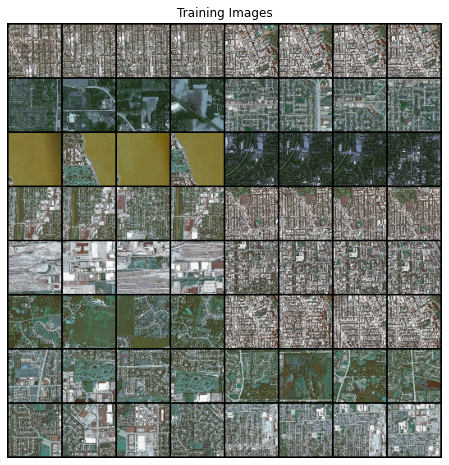

In [6]:
import torchvision.utils as vutils
temp = next(iter(dataloader))[1]
temp = torch.flatten(temp, start_dim=0, end_dim=-4)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(temp, padding=2, normalize=True).cpu(),(1,2,0)));

In [7]:
beta1 = 0.5
optimizerG = torch.optim.Adam(netG.parameters(), lr=optim_config['base_lr'], betas=(beta1, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=optim_config['base_lr'], betas=(beta1, 0.999))


In [8]:
criterion = torch.nn.BCELoss()
num_batches = len(dataloader)

fixed_noise = torch.randn(8, latent_dim, 1, 1, device=device)
noise_demo = dataset.demo_df[:8,:]        
noise_demo = noise_demo[:,:,None,None].to(device)

# row: same demo vector, different noise vectors
# column: same noise vector, different demo vectors
fixed_noise = torch.cat([fixed_noise.repeat(8,1,1,1),noise_demo.repeat_interleave(8, dim=0)], axis=1)


[0]	Loss_D: 0.1897	Loss_G: 2.9641	D(x): 0.9701	D(G(z)): 0.1451 / 0.0582
[0]	Loss_D: 0.2273	Loss_G: 2.4020	D(x): 0.9355	D(G(z)): 0.1462 / 0.0960
[0]	Loss_D: 0.7453	Loss_G: 2.5443	D(x): 0.8657	D(G(z)): 0.4445 / 0.0843
[0]	Loss_D: 1.2925	Loss_G: 4.2702	D(x): 0.8225	D(G(z)): 0.6464 / 0.0163
[0]	Loss_D: 0.8254	Loss_G: 1.0493	D(x): 0.4916	D(G(z)): 0.0774 / 0.3759
[0]	Loss_D: 0.6803	Loss_G: 1.5775	D(x): 0.8034	D(G(z)): 0.3551 / 0.2175
[0]	Loss_D: 0.9497	Loss_G: 1.4602	D(x): 0.4806	D(G(z)): 0.1376 / 0.2412
[0]	Loss_D: 1.6009	Loss_G: 1.6583	D(x): 0.7636	D(G(z)): 0.7061 / 0.2059
[0]	Loss_D: 0.4266	Loss_G: 1.8350	D(x): 0.9187	D(G(z)): 0.2833 / 0.1680
[1]	Loss_D: 1.2989	Loss_G: 1.1633	D(x): 0.3234	D(G(z)): 0.0704 / 0.3357
[1]	Loss_D: 1.0196	Loss_G: 3.0678	D(x): 0.4090	D(G(z)): 0.0368 / 0.0535
[1]	Loss_D: 0.8205	Loss_G: 1.3076	D(x): 0.5483	D(G(z)): 0.1664 / 0.2913
[1]	Loss_D: 1.2046	Loss_G: 1.5409	D(x): 0.9127	D(G(z)): 0.6501 / 0.2317
[1]	Loss_D: 2.6516	Loss_G: 1.0369	D(x): 0.9144	D(G(z)): 0.9165 /

[11]	Loss_D: 0.3467	Loss_G: 2.6310	D(x): 0.9055	D(G(z)): 0.2114 / 0.0802
[11]	Loss_D: 2.5744	Loss_G: 1.9034	D(x): 0.0895	D(G(z)): 0.0500 / 0.1617
[11]	Loss_D: 0.3294	Loss_G: 2.4194	D(x): 0.9376	D(G(z)): 0.2275 / 0.0970
[11]	Loss_D: 1.1242	Loss_G: 2.9501	D(x): 0.9148	D(G(z)): 0.6271 / 0.0585
[11]	Loss_D: 0.2052	Loss_G: 2.5270	D(x): 0.9114	D(G(z)): 0.1027 / 0.0877
[12]	Loss_D: 0.3647	Loss_G: 3.3771	D(x): 0.7178	D(G(z)): 0.0221 / 0.0375
[12]	Loss_D: 1.3355	Loss_G: 2.3415	D(x): 0.9405	D(G(z)): 0.6991 / 0.1035
[12]	Loss_D: 0.7230	Loss_G: 1.8133	D(x): 0.9745	D(G(z)): 0.4883 / 0.1742
[12]	Loss_D: 0.6693	Loss_G: 2.1340	D(x): 0.9521	D(G(z)): 0.4523 / 0.1275
[12]	Loss_D: 0.3982	Loss_G: 1.7090	D(x): 0.9345	D(G(z)): 0.2696 / 0.1961
[12]	Loss_D: 0.7755	Loss_G: 1.5658	D(x): 0.9501	D(G(z)): 0.4982 / 0.2165
[12]	Loss_D: 0.9312	Loss_G: 4.2958	D(x): 0.4209	D(G(z)): 0.0137 / 0.0163
[12]	Loss_D: 0.5356	Loss_G: 4.3306	D(x): 0.5999	D(G(z)): 0.0134 / 0.0147
[12]	Loss_D: 0.2872	Loss_G: 2.0577	D(x): 0.8318	D(G

[22]	Loss_D: 1.4101	Loss_G: 0.5998	D(x): 0.3050	D(G(z)): 0.1532 / 0.5621
[23]	Loss_D: 0.0113	Loss_G: 5.3185	D(x): 0.9968	D(G(z)): 0.0080 / 0.0060
[23]	Loss_D: 0.1016	Loss_G: 3.1024	D(x): 0.9972	D(G(z)): 0.0929 / 0.0509
[23]	Loss_D: 0.0518	Loss_G: 5.5287	D(x): 0.9570	D(G(z)): 0.0064 / 0.0051
[23]	Loss_D: 0.6028	Loss_G: 2.3264	D(x): 0.9992	D(G(z)): 0.4356 / 0.1072
[23]	Loss_D: 1.1846	Loss_G: 0.8754	D(x): 0.4506	D(G(z)): 0.2847 / 0.4351
[23]	Loss_D: 0.9693	Loss_G: 1.8480	D(x): 0.4447	D(G(z)): 0.1108 / 0.1667
[23]	Loss_D: 0.2449	Loss_G: 2.1060	D(x): 0.8443	D(G(z)): 0.0685 / 0.1330
[23]	Loss_D: 0.0758	Loss_G: 7.7531	D(x): 0.9285	D(G(z)): 0.0007 / 0.0005
[23]	Loss_D: 2.3701	Loss_G: 1.1853	D(x): 0.5876	D(G(z)): 0.8183 / 0.3221
[23]	Loss_D: 0.5319	Loss_G: 1.2921	D(x): 0.7252	D(G(z)): 0.1727 / 0.2872
[24]	Loss_D: 0.2674	Loss_G: 1.5556	D(x): 0.9810	D(G(z)): 0.2161 / 0.2263
[24]	Loss_D: 1.2339	Loss_G: 0.5742	D(x): 0.3607	D(G(z)): 0.1086 / 0.5759
[24]	Loss_D: 0.1003	Loss_G: 3.0013	D(x): 0.9884	D(G

KeyboardInterrupt: 

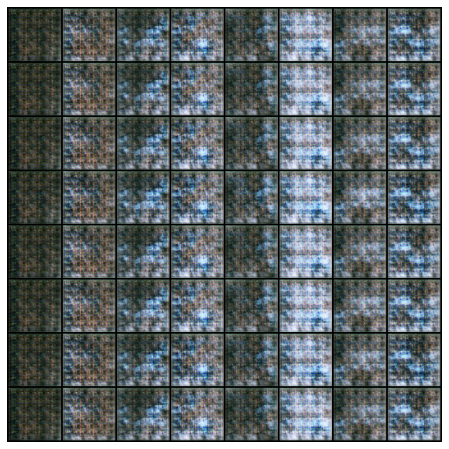

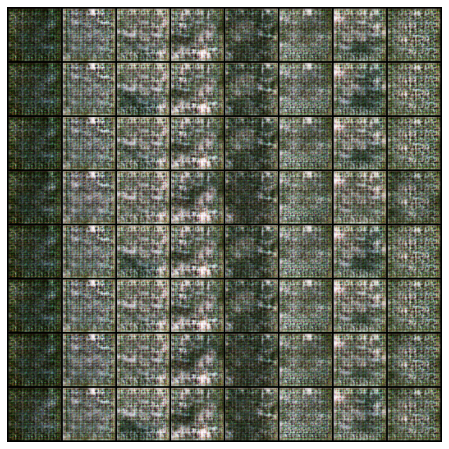

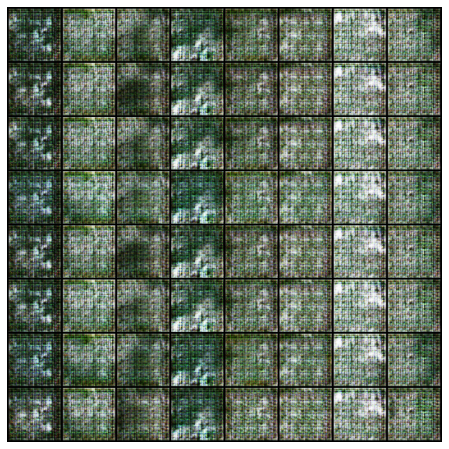

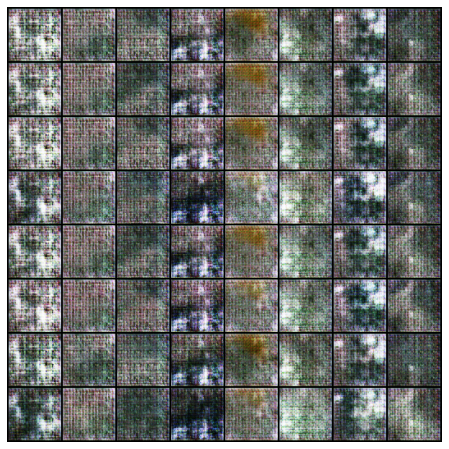

In [18]:
G_losses = []
D_losses = []

real_label = 1
fake_label = 0

start_epoch = 0
iters = 0

for epoch in range(start_epoch, start_epoch+optim_config['epochs']):
    
    loss_d = 0
    loss_g = 0

    for _, (_, data, demo) in enumerate(dataloader):
#     for data, _ in celeb_train_loader:
        data = torch.flatten(data, start_dim=0, end_dim=-4)
        demo = torch.flatten(demo, start_dim=0, end_dim=-2)
        demo_conv = demo[:,:,None,None].expand(-1,-1,int(image_size),int(image_size)).to(device)
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        # concat demo with image
        real_cpu = torch.cat((data.to(device), demo_conv),1)
        
        real_cpu = real_cpu.float().to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim, 1, 1)
        noise = torch.cat((noise, demo[:,:,None,None]), 1).float()
        noise = noise.to(device)
        
        # Generate fake image batch with G
        fake = netG(noise)
        fake = torch.cat((fake, demo_conv), 1).float()
        
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
#         loss_d += errD.item()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
#         loss_g += errG.item()
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1
        if iters % 50 == 0:
        # Output training stats
            print('[%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        
    # Check how the generator is doing by saving G's output on fixed_noise
    if epoch % 10 == 0:

        with torch.no_grad():
            fake = netG(fixed_noise.float()).detach().cpu()
        fig, ax = plt.subplots(1,1,figsize=(8,8))
        ax.axis("off")
        ax.imshow(np.transpose(torchvision.utils.make_grid(fake, padding=2, normalize=True).cpu(),(1,2,0)))
        fig.savefig(out_dir+"DCGAN/"+model_run_date+"/"+str(epoch)+".png", bbox_inches='tight')
            
        if config['run_config']['save']:
            torch.save({'epoch': epoch,
                'generator_model_state_dict': netG.state_dict(),
                'discriminator_model_state_dict': netD.state_dict(),
                'optimizerG_state_dict': optimizerG,
                'optimizerD_state_dict': optimizerD,
                'config': config},
                model_dir+"cDCGAN/cGAN_"+model_run_date+"_"+str(epoch)+".pt")

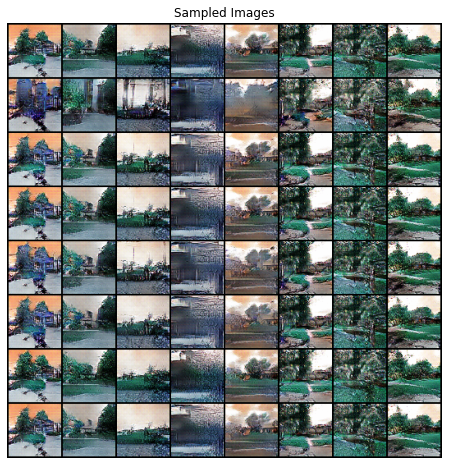

In [72]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.axis("off")
ax.set_title("Sampled Images")
ax.imshow(np.transpose(torchvision.utils.make_grid(fake, padding=2, normalize=True).cpu(),(1,2,0)))
# fig.savefig(out_dir+"GAN_"+zoomlevel+"_"+str(model_config['latent_dim'])+"_"+
#     model_run_date+".png", bbox_inches='tight')


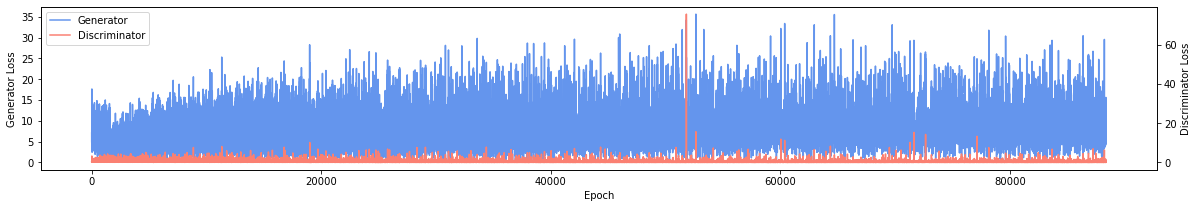

In [19]:
fig, ax = plt.subplots(1, figsize=(20,3))
ln1 = ax.plot(G_losses, label='Generator', color='cornflowerblue')
ax2 = ax.twinx()
ln2 = ax2.plot(D_losses, label='Discriminator', color='salmon')

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.set_xlabel("Epoch")
ax.set_ylabel("Generator Loss")
ax2.set_ylabel("Discriminator Loss")

# fig.savefig(out_dir+"training_plots/"+model_type+"_"+zoomlevel+"_"+str(latent_dim)+"_"+
#                 model_save_variable_names[y]+"_"+model_run_date+".png", bbox_inches='tight')
plt.show()
